# Process fgmax grid results and plot

To process fgmax results after doing a run.

In [1]:
%matplotlib inline

In [2]:
from pylab import *

In [3]:
import os,sys,glob,zipfile,shutil
from importlib import reload
from clawpack.geoclaw import topotools, dtopotools, kmltools
from clawpack.visclaw import colormaps, plottools
from clawpack.amrclaw import region_tools
from scipy.interpolate import RegularGridInterpolator
import matplotlib as mpl
from matplotlib import colors
import fgmax_tools

In [5]:
sys.path.insert(0,'../common_python')
import nc_tools
from importlib import reload
reload(nc_tools)

ModuleNotFoundError: No module named 'netCDF4'

## Set some things...

Specify the directory to read results from, and some other settings:

In [5]:
save_figs = False              # make png files for figures?
make_new_fgmax_nc_file = True  # make new netcdf file of fgmax results (possibly overwrites)?

rundir = os.path.abspath('.')
outdir = os.path.join(rundir, '_output') 

print('Will read fgmax results from outdir = \n  ', outdir)

Will read fgmax results from outdir = 
   /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/_output


In [6]:
use_force_dry = True
if use_force_dry:
    fname_force_dry = os.path.join(rundir, 'input_files', 'force_dry_init_19.data')
    #fname_force_dry = os.path.join(rundir, 'input_files', 'force_dry_init.data')
    
adjust_by_dz = True
if adjust_by_dz:
    dtopo_path = os.path.join(rundir, '/data1/dtopo/CSZ/CSZ_L1-extended-pmel.tt3')

In [7]:
def savefigp(fname):
    global save_figs
    if save_figs:
        savefig(fname)
        print('Created ', fname)
    else:
        print('save_figs = False')

## Read in and process the fgmax results from the latest run


In [8]:
t_files = glob.glob(outdir + '/fort.t0*')
times = []
for f in t_files:
    lines = open(f,'r').readlines()
    for line in lines:
        if 'time' in line: 
            t = float(line.split()[0])
    times.append(t)
times.sort()
print('Output times found: ',times)
if len(times) > 0:
    t_hours = times[-1] / 3600.
    print('\nfgmax results are presumably from final time: %.1f seconds = %.2f hours'\
          % (times[-1], t_hours))
else:
    t_hours = nan

Output times found:  [0.0, 1800.0, 3600.0, 5400.0, 7200.0, 9000.0, 10800.0, 12600.0, 14400.0, 16200.0, 18000.0, 19800.0, 21115.057]

fgmax results are presumably from final time: 21115.1 seconds = 5.87 hours


In [9]:
# Read fgmax data:
fg = fgmax_tools.FGmaxGrid()
fgmax_input_file_name = outdir + '/fgmax_grids.data'
print('fgmax input file: \n  %s' % fgmax_input_file_name)
fg.read_fgmax_grids_data(fgno=1, data_file=fgmax_input_file_name)

fg.read_output(outdir=outdir)

fgmax input file: 
  /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/_output/fgmax_grids.data
Reading input for fgno=1, point_style = 4 
Reading /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/_output/fgmax0001.txt ...
point_style == 4, found 1823680 points 
Will map fgmax points onto masked arrays defined by file:
     /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/input_files/fgmax_pts_nri_arrival_1.data
Deduced dx = 0.000277778, dy = 0.000277778
converted level to 2d array
converted B to 2d array
converted h to 2d array
converted h_time to 2d array
not converting attribute s == None
not converting attribute s_time == None
not converting attribute hs == None
not converting attribute hs_time == None
not converting attribute hss == None
not converting attribute hss_time == None
not converting attribute hmin == None
not converting attribute hmin_time == None
con

In [10]:
# convert to masked array on uniform grid for .nc file and plots:

#fgm = fgmax_tools.FGmaxMaskedGrid()
#dx = dy = 1./(3*3600.)  # For 1/3 arcsecond fgmax grid

# convert to arrays and create fgm.X etc.
#fgm.convert_lists_to_arrays(fg,dx,dy) 

# 1d versions of X and Y arrays:
#fgm.x = fgm.X[0,:]
#fgm.y = fgm.Y[:,0]

#dx = dy = 1./(3*3600.)  # For 1/3 arcsecond fgmax grid

# convert to masked array on uniform grid for .nc file and plots:
fg = fgmax_tools.FGmaxGrid()
fgmax_input_file_name = outdir + '/fgmax_grids.data'
fg.read_fgmax_grids_data(fgno=1, data_file=fgmax_input_file_name)
fg.read_output(outdir=outdir)

Reading input for fgno=1, point_style = 4 
Reading /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/_output/fgmax0001.txt ...
point_style == 4, found 1823680 points 
Will map fgmax points onto masked arrays defined by file:
     /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS/input_files/fgmax_pts_nri_arrival_1.data
Deduced dx = 0.000277778, dy = 0.000277778
converted level to 2d array
converted B to 2d array
converted h to 2d array
converted h_time to 2d array
not converting attribute s == None
not converting attribute s_time == None
not converting attribute hs == None
not converting attribute hs_time == None
not converting attribute hss == None
not converting attribute hss_time == None
not converting attribute hmin == None
not converting attribute hmin_time == None
converted arrival_time to 2d array
converted h0 to 2d array


In [11]:
# compute subsidence/uplift at each fgmax point:

if adjust_by_dz:
    dtopo = dtopotools.DTopography()
    dtopo.read(dtopo_path, dtopo_type=3)
    x1d = dtopo.X[0,:]
    y1d = dtopo.Y[:,0]
    dtopo_func = RegularGridInterpolator((x1d,y1d), dtopo.dZ[-1,:,:].T, 
                    method='linear', bounds_error=False, fill_value=0.)
    dz = dtopo_func(list(zip(ravel(fg.X), ravel(fg.Y))))
    fg.dz = reshape(dz, fg.X.shape)
    print('Over fgmax extent, min(dz) = %.2f m, max(dz) = %.2f m' \
         % (dz.min(), dz.max()))
else:
    fg.dz = zeros(fg.X.shape)

fg.B0 = fg.B - fg.dz   # original topo before subsidence/uplift

Over fgmax extent, min(dz) = -0.58 m, max(dz) = 0.00 m


In [12]:
if use_force_dry:
    print('Reading force_dry from ',fname_force_dry)
    force_dry = topotools.Topography()
    force_dry.read(fname_force_dry, topo_type=3)
    dx = fg.x[1] - fg.x[0]
    dy = fg.y[1] - fg.y[0]
    i1 = int(round((fg.x[0]-force_dry.x[0])/dx))
    i2 = int(round((fg.x[-1]-force_dry.x[0])/dx))
    j1 = int(round((fg.y[0]-force_dry.y[0])/dy))
    j2 = int(round((fg.y[-1]-force_dry.y[0])/dy))
    if (i1<0) or (i2-i1+1 != len(fg.x)) or \
       (j1<0) or (j2-j1+1 != len(fg.y)):
        print('*** force_dry does not cover fgm extent, not using')
        use_force_dry = False
        fg.force_dry_init = None
    else:
        fg.force_dry_init = force_dry.Z[j1:j2+1, i1:i2+1]
else:
    fg.force_dry_init = None
    print('*** use_force_dry is False')

if fg.force_dry_init is not None:
    fg.h_onshore = ma.masked_where(fg.force_dry_init==0, fg.h)
else:
    fg.h_onshore = ma.masked_where(fg.B0 < 0., fg.h)
    

*** use_force_dry is False


In [13]:
print('Number of fgmax points: ', fg.h.count())

Number of fgmax points:  1823680


No force_dry_init array


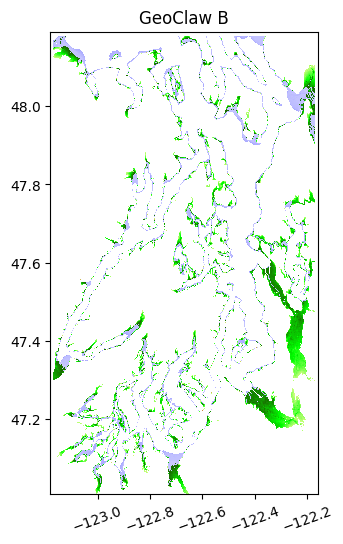

In [14]:
zmin = -60.
zmax = 40.
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)                                   

def plotZ(Z, show_cb=True):
    pc = plottools.pcolorcells(fg.X, fg.Y, Z, cmap=cmap, norm=norm)  
    if show_cb:
        cb = colorbar(pc,shrink=0.5)
        cb.set_label('meters')
    #axis([-122.76,-122.525,47.95,48.2])
    gca().set_aspect(1./cos(48*pi/180.))
    ticklabel_format(useOffset=False)
    xticks(rotation=20);
    
figure(figsize=(10,6))
subplot(121)
plotZ(fg.B, show_cb=False)
title('GeoClaw B');

if fg.force_dry_init is not None:
    print('Found force_dry_init array')
    subplot(122)
    mask_all_but_dryneg = logical_or(logical_or(fg.B.mask, 
                                                logical_not(fg.force_dry_init)), 
                                     fg.B0>0)
    B_dryneg = ma.masked_array(fg.B.data, mask=mask_all_but_dryneg)
    plotZ(fg.B, show_cb=False)
    
    sea_cmap_dry = colormaps.make_colormap({ 0.0:[1.0,0.6,0.6], 1.:[1.0,0.6,0.6]})
    cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, sea_cmap_dry),
                                         data_limits=(zmin,zmax),
                                         data_break=0.)
    B0_dryneg = ma.masked_array(fg.B0.data, mask=mask_all_but_dryneg)
    plottools.pcolorcells(fg.X, fg.Y, B0_dryneg, cmap=cmap_dry, norm=norm_dry)
    title('B0, with dry regions below MHW pink')
    savefigp('geoclaw_topo_and_dry.png')
else:
    print('No force_dry_init array')

In [15]:
if fg.force_dry_init is not None:
    print('Found force_dry_init array')
    subplot(122)
    mask_all_but_dryneg = logical_or(logical_or(fg.B.mask, 
                                                logical_not(fg.force_dry_init)), 
                                     fg.B0>0)
    B_dryneg = ma.masked_array(fg.B.data, mask=mask_all_but_dryneg)
    plotZ(fg.B, show_cb=False)
    
    sea_cmap_dry = colormaps.make_colormap({ 0.0:[1.0,0.6,0.6], 1.:[1.0,0.6,0.6]})
    cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, sea_cmap_dry),
                                         data_limits=(zmin,zmax),
                                         data_break=0.)
    B0_dryneg = ma.masked_array(fg.B0.data, mask=mask_all_but_dryneg)
    plottools.pcolorcells(fg.X, fg.Y, B0_dryneg, cmap=cmap_dry, norm=norm_dry)
    title('Eagle Harbor: 1,040,374 fgmax points (dry regions below MHW pink)')
else:
    print('No force_dry_init array')

No force_dry_init array


In the plot above, "GeoClaw B" refers to the cell-averaged topography value used by GeoClaw and stored with the fgmax output, and is generally recorded after any subsidence/uplift.  The colors are blues for values of $B < 0$ and greens/brown for $B > 0$.  If there's a plot on the right, it shows as pink any areas that were initialized as dry in spite of having $B_0 < 0$, where $B_0$ is the initial topography ($B$ corrected by $dz$).

## Write output to netCDF file

The next cell will add fgmax results to a copy of the `input_guemes_channel_19.nc` file containing input data that was created by [MakeInputFiles_Guemes_Channel.ipynb](MakeInputFiles_Guemes_Channel.ipynb). The `input_guemes_channel_19.nc` file contains the original topo values as well as the `fgmax_point` array that indicates which of these are fgmax points.

The new file is called `results_guemes_channel_19_L1_MHW.nc`.

**WARNING:** This will overwrite any previous `results.nc` file with same file name!

In [16]:
fname = 'results_Eagle_Harbor_arrival_19_L_MHW.nc'
fname_input = 'input_eagle_harbor.nc'
print('Copying %s to %s' % (fname_input, fname))
#os.system('cp %s %s' % (fname_input, fname))    
shutil.copyfile(fname_input, fname)
#fgmax_tools.write_nc_output(fname, fg, outdir=outdir, force=False)
nc_tools.write_nc_output(fname, fg, outdir=outdir, force=True)

Copying input_nri_arrival_time_PS_1.nc to results_nri_arrival_PS_1_L1_MHW.nc
/data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS
Appending data from fg to nc file results_nri_arrival_PS_1_L1_MHW.nc
        nc file description:  fgmax data for NRI_arrival_time_1
        fg.id:  
    Adding fg.dz to nc file
    Adding fg.B to nc file
    Adding fg.h to nc file
fg.s is None, not adding
fg.hss is None, not adding
fg.hmin is None, not adding
    Adding fg.arrival_time to nc file
    Adding fg.tfirstWARN to nc file
    Adding fg.tfirstADVIS to nc file
    Adding fg.tfirstDRAW to nc file
    Adding fg.tfirstPOS to nc file
    Adding fg.tfirstNEG to nc file
Created results_nri_arrival_PS_1_L1_MHW.nc
History:   Created with input data Mon Mar  4 22:19:12 2024 in /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_1sec_arrival_time_NRI_PS;  Added output Mon Mar 25 08:59:04 2024 in /data1/clawpack_src/clawpack-v5.9.0/geoclaw/examples/tsunami/CSZ_